# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Решение поставленной задачи будем решать поэтапно:
1. Подготовка данных. На данном этапе произведём:
    - Загрузку и первичный анализ данных;
    - Анализ признаков;
    - Предобработку данных;
    - Подготовку выборок для построения моделей.
2. Обучение моделей. Произведём обучение и подбор гиперпараметров нескольких моделей машинного обучения.
3. Проанализируем обученные модели, оценим их работу с точки зрения качества, времени обучения и предсказания. Сделаем окончательный выбор модели, которая пойдёт в производство.


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Вижу твое добавленное описание проекта. Молодец! Я бы посоветовал тебе чуть подробнее раскрыть план своей работы. Это поможет тебе расставлять акценты в выводах.

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.stats import randint
from scipy.sparse import vstack
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

## Подготовка данных

Подготовку данных будем производить в следующей последовательности:
1. Загрузка и первичный анализ данных;
2. Анализ признаков;
3. Предобработка данных;
4. Подготовка выборок для построения модели машинного обучения.

### Загрузка данных и первичный анализ

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])
except:
    df = pd.read_csv('D:/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [3]:
def data_info(df):
    """Изучение датасета"""
    display(df.head())
    display(df.info())
    display(df.describe())
    print('Количество дубликатов =', df.duplicated().sum())
    # Построение корреляционной матрицы
    plt.figure(figsize=(10,5))
    corr_matrix = sns.heatmap(df.corr(),annot=True)
    corr_matrix.axes.set_title("Корреляционная матрица", fontsize=16)
    # Построение парных графиков
#     sns.pairplot(df);
    plt.show()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество дубликатов = 4


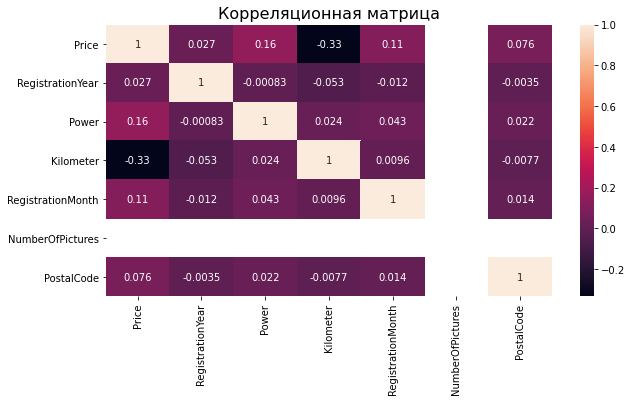

In [4]:
data_info(df)

**Вывод:**

Данные загружены и изучены. В ходе первичного анализа данных выявлены следующие особенности:
1. На этапе загрузки данных определили тип колонок `DateCrawled`, `DateCreated` и `LastSeen` как datetime.
2. Пропуски: 
    - Явные: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`
3. Колонка `NumberOfPictures` состоит полностью из нулей.
4. Аномальные данные:
    - `Price` - цена не может быть = 0, если только это не благотворительный автосалон;
    - `RegistrationYear`- год регистрации не может быть = 1000, автомобили тогда ещё не изобрели; 
    - `RegistrationMonth` - месяц регистрации не может быть = 0
    - `Power` - мощьность двигателя не может быть = 0, только если это не прицеп.
5. Есть 4 полных дубликата строк.
    

### Исследование признаков

Для лучшего понимания информации содержащейся в наборе данных и качественной предобработки, проведём исследоватние признаков. С этой целью произведём:
1. Исследование информации в колонках, содержащих дату и время(`DateCrawled`, `DateCreated`, `LastSeen`, `RegistrationYear`, `RegistrationMonth`);
2. Исследование категориальных данных(`VehicleType`, `Model`, `Brand`, `FuelType`, `NotRepaired`, `Gearbox`, `PostalCode`);
3. Исследование численных данных(`Price`, `Power`, `Kilometer`)

#### Исследование информации в колонках, содержащих дату и время


Исследуем информацию в колонках: DateCrawled, DateCreated, LastSeen, RegistrationYear, RegistrationMonth

**Год регистрации автомобиля `RegistrationYear`**

Проанализуруем распределение объявлений по году регистрации транспортного средства. Произведём расчёт усов диаграмы размаха. Затем определим количество недостоверных данных и примем решение о способе обработки данных в этой колонке.

In [5]:
def moustache(col):
    """ Функция принимает колонку
        Возвращает нижние и верхние усы диаграмы размаха
    """
    irq = (col.quantile(0.75) - col.quantile(0.25))*1.5
    return max(col.quantile(0.25) - irq , col.min()), min(col.quantile(0.75) + irq, col.max())

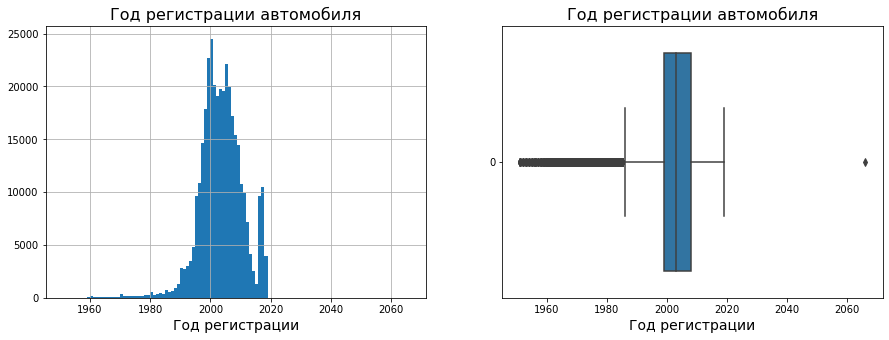

In [6]:
fig = plt.figure(figsize=(15,5))

ax_1 = fig.add_subplot(1, 2, 1)
ax_1 = df[(df['RegistrationYear'] > 1950) & (df['RegistrationYear'] < 2070)]['RegistrationYear'].hist(bins=115)
ax_1.set_title('Год регистрации автомобиля', fontsize=16)
ax_1.set_xlabel('Год регистрации', fontsize=14)

ax_2 = fig.add_subplot(1, 2, 2)
ax_2 = sns.boxplot(data=df[(df['RegistrationYear'] > 1950) & (df['RegistrationYear'] < 2070)]['RegistrationYear'], orient='h')
ax_2.axes.set_title('Год регистрации автомобиля', fontsize=16)
ax_2.set_xlabel('Год регистрации', fontsize=14)

plt.show();

In [7]:
# Нижний и верхний ус
moustache(df['RegistrationYear'])

(1985.5, 2021.5)

In [8]:
df[df['RegistrationYear'] < 1960].head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16,0,44628,2016-03-20 16:44:37
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15,0,79288,2016-04-07 05:15:34
3333,2016-03-15 21:36:20,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN,2016-03-15,0,53498,2016-04-07 08:16:11


In [9]:
df[df['RegistrationYear'] < 1985].shape[0]

5448

In [10]:
# в датасете данные за 2014-2016 год, поэтому, год регистрации ТС не может быть больше 2016 ????
df[df['RegistrationYear'] > 2016].shape[0]

14530

Проанализировав данные о годе регистрации автомобиля выявлены следующие особенности:
1. Как было отмечено в выводе по предыдущему разделу, в данной инфомации есть явно недостоверные данные. Это значения от 1000 до 1900 и более настоящего времени.
2. Распределение года регистрации похоже на нормальное, но с небольшой аномалией в районе 2017-2018 года.
3. В объяалениях с годом регистрации автомобиля ранее 1960 года содержится много не достоверных данных. Например строка с индексом 15: Ford Ka начал выпускаться с 1996 года, а здесь он значится с годом регистрации 1910.
4. На этапе предобработки данных, необходимо будет удалить данные с годом регистрации автомобиля по нижниму усу диаграмы размаха - до 1985, и позднее 2016 года как . 

**Месяц регистрации автомобиля `RegistrationMonth`**

Проанализируем распределение объявлений о продаже по месяцу регистрации автомобиля и посмотрим количество записей с нулевым месяцем.

In [11]:
print('Количество записей с месяцем = 0:', df[df['RegistrationMonth'] == 0].shape[0])

Количество записей с месяцем = 0: 37352


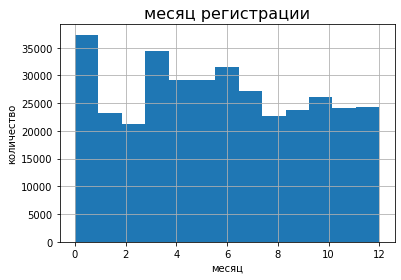

In [12]:
# Построение распределения месяца регистрации
ax = df['RegistrationMonth'].hist(bins=13)
ax.set_title('месяц регистрации', fontsize=16)
ax.set(ylabel='количество', xlabel= 'месяц')
plt.show;

Анализ гистограммы распределения месяца регистрации говорит о том, что в целом, объявления распределены по месяцам практически равномерно. Однако, присутствует месяц с номером 0, чего быть не должно. Скорее всего, ноль здесь означает, что месяц регистрации не известен. Если его заменить на какй-либо реальный номер месяца, то нарушется существующее распределение.  Поэтому будет правильно оставить нулевой месяц как есть.

**Дата последней активности пользователя, создания и скачивания объявления**

Оценим границы диапозонов дат создания и скачивания объявления, а также дат последней активности пользователя.

In [13]:
pd.DataFrame(data=[[df['DateCrawled'].min(), df['DateCrawled'].max()],
                   [df['DateCreated'].min(), df['DateCreated'].max()],
                   [df['LastSeen'].min(), df['LastSeen'].max()]],
             index=['DateCrawled', 'DateCreated', 'LastSeen'],
             columns=['min', 'max']
             )

,min,max
DateCrawled,2016-03-05 14:06:22,2016-04-07 14:36:58
DateCreated,2014-03-10 00:00:00,2016-04-07 00:00:00
LastSeen,2016-03-05 14:15:08,2016-04-07 14:58:51


В представленном наборе данных, находится информация из объявлений о продаже автомобилей, размещённых в период с 10 марта 2014 года по 07 апреля 2016 года, и скачанных в марте-апреле 2016 года. Последняя активность пользователей датируется также мартом-апрелем 2016 года.

**Вывод**


Анализ дат в наборе данных выявил следующие особенности:
1. Аномальные данные года регистрации автомобиля. В наборе данных присутствуют сведенья об автомобилях с датой регистрации позднее 2016 года, а этого быть не могло. Об этом говорят даты создания, даты скачивания объявлений и даты последней активности пользователей. Анализируя распределение года регистрации автомобиля видно, что данные за 2017-2018 годы, как будто добавлены в датасет искуственно(они выделяются на гистограмме распределения). При решении реальной задачи, было бы необходимо обратится за разъяснениями к тому кто предоставил данные. Записи с годом регистрации автомобиля позднее 2016 года стоит удалить как недостоверные. Также, необходимо удалить из данных записи с годом регистрации автомобилей до 1985 года(по нижнему усу диаграмы размаха).
2. Аномалии в месяце регистрации автомобиля. Хотя нулевого месяца не существует, его удаление будет означать потерю большой части данных. Примем к сведенью, что нулевой месяц обозначает то, что месяц регистрации нам не известен.


#### Анализ категориальных данных

Проанализируем данные в колонках: `VehicleType`, `Model`, `Brand`, `FuelType`, `NotRepaired`, `Gearbox`, `PostalCode`.



**Тип кузова автомобиля**

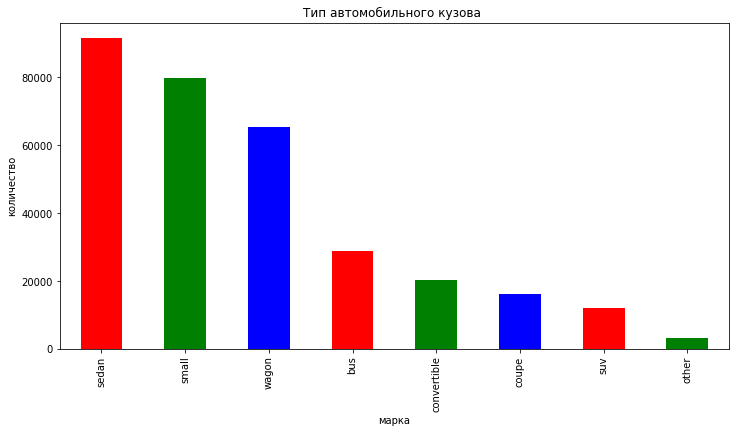

In [14]:
# Построение распределения типа кузова
df['VehicleType'].value_counts().plot(kind='bar', 
                                      figsize=(12,6), 
                                      title='Тип автомобильного кузова ', 
                                      xlabel='марка',
                                      ylabel='количество',
                                      color=['r','g','b']);

**Марка автомобиля**

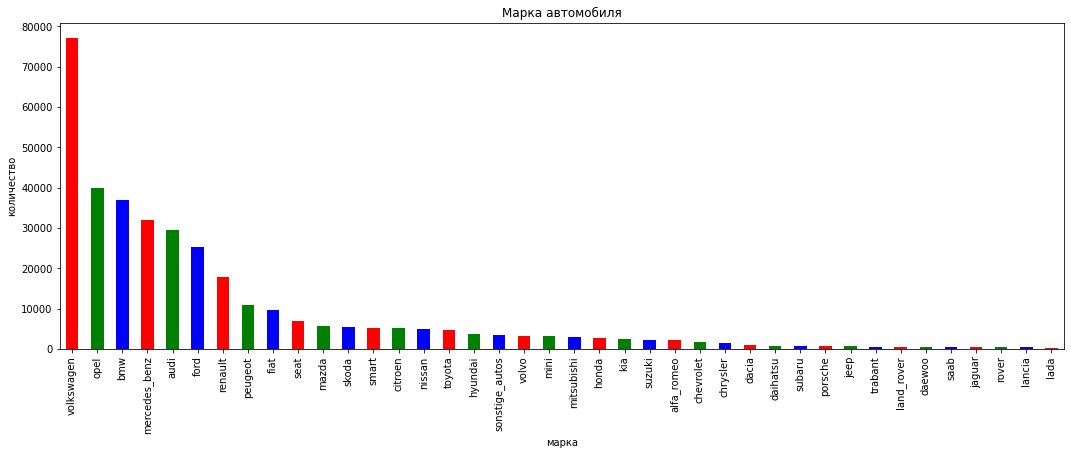

In [15]:
# Построение распределения марки автомобиля
df['Brand'].value_counts().plot(kind='bar', 
                                figsize=(18,6), 
                                title='Марка автомобиля',
                                xlabel='марка',
                                ylabel='количество',
                                color=['r','g','b']
                                );

In [16]:
print('Количество марок автомобиля:', df['Brand'].value_counts().shape[0])

Количество марок автомобиля: 40


**Тип топлива**

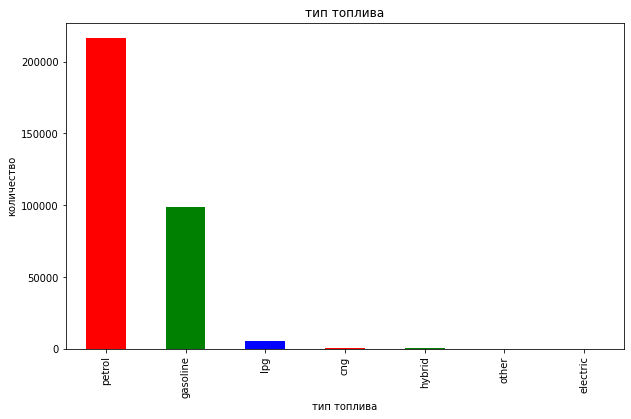

In [17]:
# Построение распределения по типу топлова
df['FuelType'].value_counts().plot(kind='bar', 
                                   figsize=(10,6), 
                                   title='тип топлива',
                                   xlabel='тип топлива',
                                   ylabel='количество',
                                   color=['r','g','b']
                                   );

**Модель автомобиля**

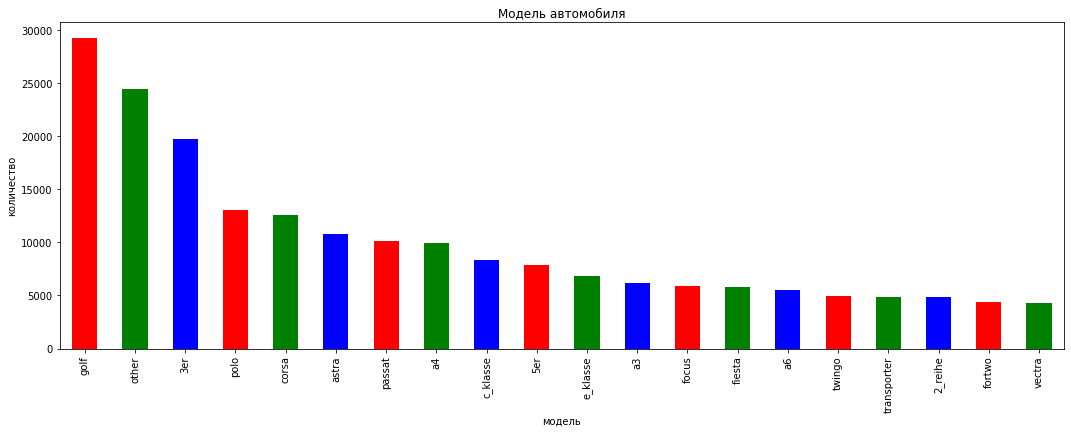

In [18]:
# Построение распределения моделей автомобиля
df['Model'].value_counts().head(20).plot(kind='bar', 
                                         figsize=(18,6), 
                                         title='Модель автомобиля',
                                         xlabel='модель',
                                         ylabel='количество',
                                         color=['r','g','b']
                                         );

In [19]:
print('Количество моделей автомобилей:',df['Model'].value_counts().shape[0])

Количество моделей автомобилей: 250


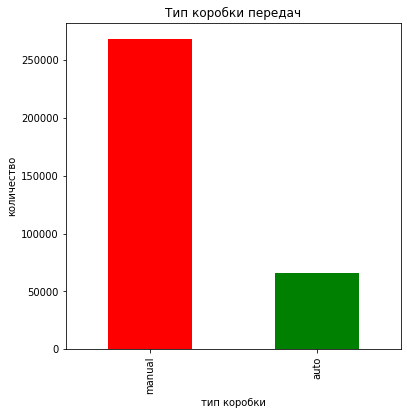

In [20]:
# Построение распределения по типу коробок передач
df['Gearbox'].value_counts().plot(kind='bar', 
                                  figsize=(6,6), 
                                  title='Тип коробки передач',
                                  xlabel='тип коробки',
                                  ylabel='количество',
                                  color=['r','g']
                                 );

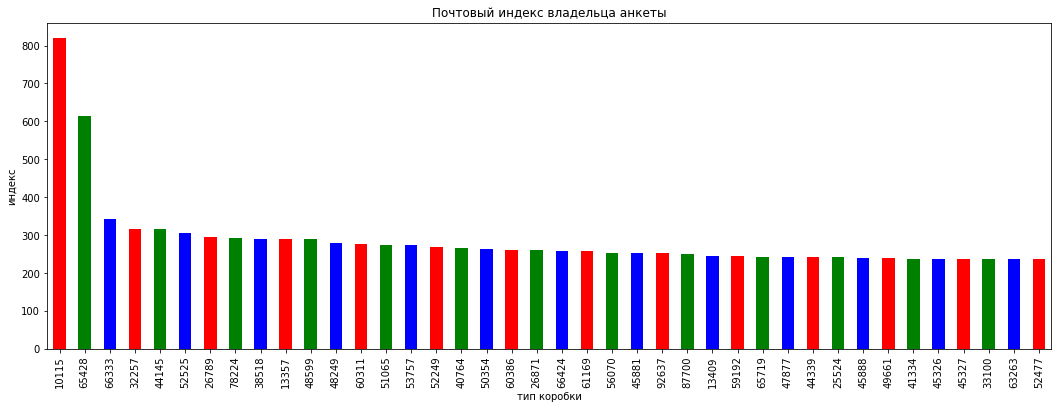

In [21]:
# Построение распределения по почтовому индексу
df['PostalCode'].value_counts().head(40).plot(kind='bar', 
                                              figsize=(18,6), 
                                              title='Почтовый индекс владельца анкеты',
                                              xlabel='тип коробки',
                                              ylabel='индекс',
                                              color=['r','g','b']
                                              );

In [22]:
print('Количество почтовых индексов:', df['PostalCode'].unique().shape[0])

Количество почтовых индексов: 8143


**Вывод**

1. Представлено 40 марок автомобилей, 250 моделей, 9 типов кузова. Самая популярная марка автомобиля - volkswagen, модель - volkswagen	golf. 
2. Самый популярный тип кузова - седан.
3. Представлено 2 типа коробок передач. Автомобилей с механической коробкой передач в 5 раз больше чем с автоматической.
4. Большенство автомобилей используют обычное топливо.
5. География продаж - северная америка и европа. Всего представленно 8143 почтовых индексов.
6. Особенностей данных в категориальных признаках, требующих обработки, не выявлено.

#### Анализ численных данных

Проанализируем данные в колонках: `Price`, `Power`, `Kilometer`

In [23]:
def feature_analiser(data, title, x_label):
    """ Функция принимает колонку, заголовок и подпись оси Х
        Выводит на экран гистограмму распределения и диаграму размаха
    """
    fig = plt.figure(figsize=(15,5))
    # Вывод гистограмы
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_1 = sns.histplot(data=data)
    ax_1.axes.set_title(title, fontsize=16)
    ax_1.set_xlabel(x_label, fontsize=14)
    
    # Вывод диаграмы размаха
    ax_2 = fig.add_subplot(1, 2, 2)
    ax_2 = sns.boxplot(data=data, orient='h')
    ax_2.axes.set_title(title, fontsize=16)
    ax_2.set_xlabel(x_label, fontsize=14)
    # boxplot.set_ylabel("Продажи", fontsize=14)

    plt.show();

**Price**

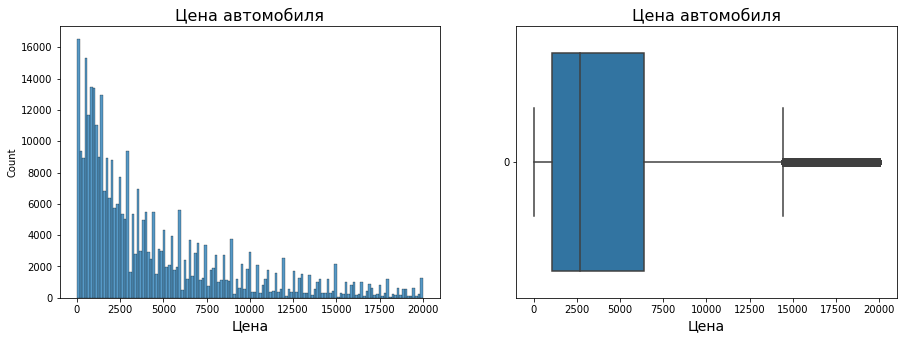

In [24]:
feature_analiser(df['Price'], 'Цена автомобиля', 'Цена')

In [25]:
# Нижний и верхний ус
moustache(df['Price'])

(0, 14425.0)

In [26]:
print('Количество записей с ценой < 100:',df[df['Price'] < 100]['Price'].shape[0])
print('Доля записей с ценой < 100:', df[df['Price'] < 100]['Price'].shape[0]/df.shape[0])

Количество записей с ценой < 100: 13314
Доля записей с ценой < 100: 0.03757100649323163


**Вывод:** Цены на автомобили лежат в диапозоне от 0 до 20000. Нулевых и около нулевых значений цены в наборе данных  около 4%. Придётся такие недостоверные данные удалить, так как цена является целевым признаком для будущей модели МО, и такие отклонения от нормы не допустимы. Удалять значения цены больше верхнего уса диаграмы размаха ме будем, так как максимальная цена в 20000 вполне допустима, и при этом можно лишиться данных о автомобилях верхнего ценового сегмента.

**Power**



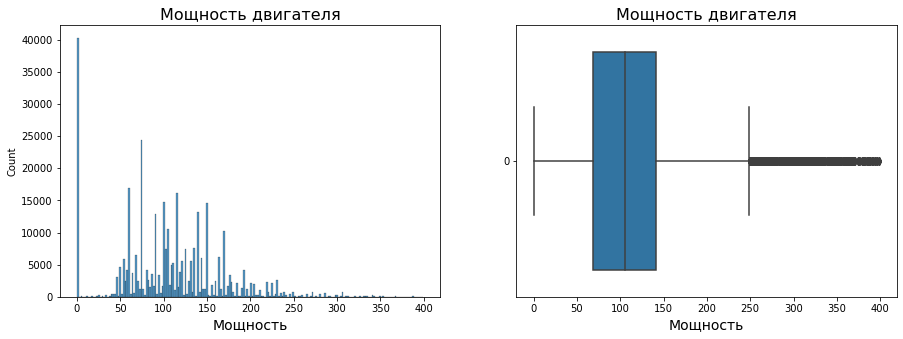

In [27]:
feature_analiser(df[df['Power'] < 400]['Power'], 'Мощность двигателя', 'Мощность')

In [28]:
# Нижний и верхний ус
moustache(df['Power'])

(0, 254.0)

In [29]:
print('Количество записей с мощьностью двигателя = 0:', df[df['Power'] == 0].shape[0])
print('Доля записей  с мощьностью двигателя = 0:', df[df['Power'] == 0].shape[0]/df.shape[0])

Количество записей с мощьностью двигателя = 0: 40225
Доля записей  с мощьностью двигателя = 0: 0.11351162206626426


In [30]:
print('Количество записей с мощьностью двигателя > 254:', df[df['Power'] > 254].shape[0])
print('Доля записей с мощьностью двигателя > 254:', df[df['Power'] > 254].shape[0]/df.shape[0])

Количество записей с мощьностью двигателя > 254: 7340
Доля записей с мощьностью двигателя > 254: 0.02071287273999701


Нижнюю границу мощности двигателя автомобиля определим как 40. Однако, объектов с нулевым значением мощьности в наборе данных около 10%, поэтому удалв их мы потеряем значительную часть данных. Думаю, стоит оставить нулевые значения в таком виде, имея в виду, что на самом деле они являются пропусками. С большими значениями ситуация сложнее. Здесь явно присутствуют ошибки в порядке значений. Если значения более 1000 и более 10000 необходимо разделить на 10 и 100 соответственно, то со значениями примерно от 250 до 1000 всё сложнее. В этом диапозоне значения с ошибками на порядок перемешанны со значениями похожими на истинные. Так как значений более 254 около 2% от всех данных, то просто ограничим набор данных по верхнему усу диаграмы размаха = 254.

**Пробег**

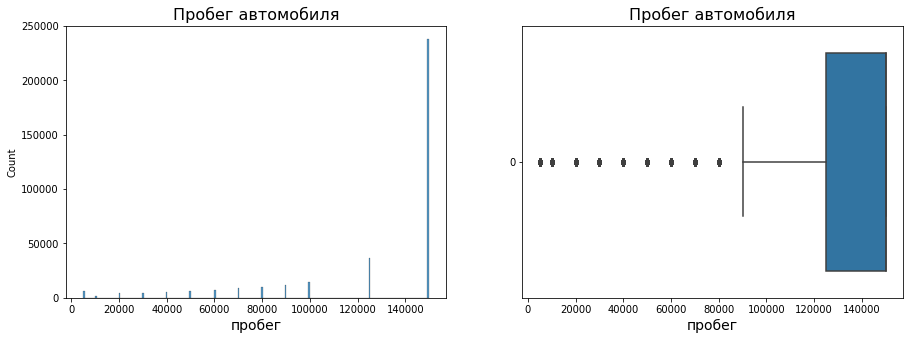

In [31]:
feature_analiser(df['Kilometer'], 'Пробег автомобиля', 'пробег')

Большенство автомобилей продаются с пробегом от 120000 до 140000, гораздо реже выставляются на продажу автомобили с мленьким пробегом. 

**Вывод**

1. Необходимо удалить из набора данных записи с околонулевыми ценами.
2. Записи с аномально большими значениями мощности двигателя необходимо удалить (более 254).
3. Данные по пробегу не требуют предобработки.

### Предобработка данных

1. Обработка пропусков и дубликатов;
2. Обработка аномальных данных

#### Обработка пропусков и дубликатов
1. Удалим колонку `NumberOfPictures`, которая состоит полностью из нулей;
2. Удалим дубликаты строк;
3. Обработка пропусков:
    - `VehicleType` - попробуем восстановить по модели автомобиля;
    + `Gearbox` - заменим на самую распространённую коробку передач `manual`;
    + `Model` - заменим на `other`;
    + `FuelType` - заменим на наиболее часто встречающееся топливо `petrol`;
    + `NotRepaired` - заменим на `unknown` так как достоверных данных в таблице нет.

In [32]:
# Удаляем колонку NumberOfPictures
df = df.drop('NumberOfPictures', axis=1)
# Удаляем дубликаты
df = df.drop_duplicates()

In [33]:
# Заполняем пропуски
df['Gearbox'] = df['Gearbox'].fillna('manual')
df['Model'] = df['Model'].fillna('other')
df['FuelType'] = df['FuelType'].fillna('petrol')
df['NotRepaired'] = df['NotRepaired'].fillna('unknown')

**Заполнение пропусков в типе ТС**

Тип транспортного средства можно получить по его модели. Так как у одной модели автомобиля может быть несколько исполнений кузова, необходимо выбрать наиболее распрастранённый тип для этой модели. 
1. Составим словарь соответствия модель ТС - самый часто встречающийся тип ТС для данной модели;
2. В соответствии с полученным словарём заполним пропуски в типе ТС.

In [34]:
# Создаём словарь типов транспортных средств по модели
# Создадим сводную таблицу по модели и типам кузова
type_dict = df[df['Model'].notna()].pivot_table(index='Model', columns='VehicleType', values='Brand', aggfunc='count')
# Список типов кузова
model=type_dict.columns.values
# Добавляем колонку с наиболее часто встречающимся типом кузова для данной модели
type_dict['most_friqued'] = type_dict[model].apply(lambda x: model[x.argmax()], axis=1)
type_dict.head()

VehicleType,bus,convertible,coupe,other,sedan,small,suv,wagon,most_friqued
Model,,,,,,,,,
100,NaN,1.0,2.0,NaN,278.0,NaN,NaN,109.0,sedan
145,NaN,NaN,2.0,1.0,13.0,19.0,NaN,NaN,small
147,NaN,NaN,27.0,7.0,358.0,97.0,1.0,2.0,sedan
156,NaN,NaN,3.0,1.0,287.0,2.0,NaN,288.0,wagon
159,NaN,NaN,NaN,NaN,55.0,NaN,NaN,145.0,wagon


In [35]:
# Заполняем пропуски
df.loc[df['VehicleType'].isna(), 'VehicleType'] = df[df['VehicleType'].isna()]['Model'].apply(lambda x: type_dict.loc[x,'most_friqued'])

In [36]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,60437,2016-04-06 10:17:21


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354365 non-null  datetime64[ns]
 1   Price              354365 non-null  int64         
 2   VehicleType        354365 non-null  object        
 3   RegistrationYear   354365 non-null  int64         
 4   Gearbox            354365 non-null  object        
 5   Power              354365 non-null  int64         
 6   Model              354365 non-null  object        
 7   Kilometer          354365 non-null  int64         
 8   RegistrationMonth  354365 non-null  int64         
 9   FuelType           354365 non-null  object        
 10  Brand              354365 non-null  object        
 11  NotRepaired        354365 non-null  object        
 12  DateCreated        354365 non-null  datetime64[ns]
 13  PostalCode         354365 non-null  int64   

**Вывод:** Произведена обработка пропусков и дубликатов.

#### Обработка аномальных данных

По результатам анализа признаков необходимо обработать данные в колонках:
- `RegistrationYear`- удалим из данных записи с годом регистрации автомобилей по нижнему усу диаграмы размаха до 1985 года, и как недостоверные, позднее 2016 года;
- `Price` - удалим записи с ценой менее 100.
- `Power` - Избавимся от записей со значениями мощности более 254. 

**RegistrationYear**

Обрежем данные, содержащие год регистрации по усам диаграммы размаха

In [38]:
# Удаление данных с недостоверным годом
min_mus, max_mus = moustache(df['RegistrationYear'])
df = df[df['RegistrationYear'] >= min_mus]
df = df[df['RegistrationYear'] <= 2016]

**Price**

 Данная колонка является целевым признаком для будущей модели, поэтому оставить 0 здесь нет возможности.

In [39]:
# Исключим из набора данных автомобили цены которых ниже 100
df = df[df['Price'] > 100]

**Power**

Исключим из набора данных записи со значением мощьности двигателя по верхнему усу диаграмы размаха(более 254).

In [40]:
# Исключим из набора данных автомобили со значением мощьности двигателя менее верхнего уса(254).
min_mus, max_mus = moustache(df['Power'])
df = df[df['Power'] <= max_mus]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313227 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        313227 non-null  datetime64[ns]
 1   Price              313227 non-null  int64         
 2   VehicleType        313227 non-null  object        
 3   RegistrationYear   313227 non-null  int64         
 4   Gearbox            313227 non-null  object        
 5   Power              313227 non-null  int64         
 6   Model              313227 non-null  object        
 7   Kilometer          313227 non-null  int64         
 8   RegistrationMonth  313227 non-null  int64         
 9   FuelType           313227 non-null  object        
 10  Brand              313227 non-null  object        
 11  NotRepaired        313227 non-null  object        
 12  DateCreated        313227 non-null  datetime64[ns]
 13  PostalCode         313227 non-null  int64   

In [42]:
print('Доля оставшихся данных после предобработки:', round(df.shape[0]/354369, 2))

Доля оставшихся данных после предобработки: 0.88


**Вывод**

В ходе предобработки избавились от пропусков, дубликатов и обработали некоторые недостоверные данные. При этом, лишились около 12% данных.

### Подготовка выборок

1. Целевой признак: `Price`;
2. Числовые признаки: `RegistrationYear`,	`Power`, `Kilometer`,	`RegistrationMonth`;
3. Категориальные признаки: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `NotRepaired`, `PostalCode`;
4. Колонки с датами скачивания анкеты из базы `DateCrawled`, дата создания анкеты `DateCreated`, дата последней активности пользователя`LastSeen` использовать не будем, так как признаком даты в обучающей выборке будут колонки `RegistrationYear` и `RegistrationMonth`
4. Произведём кодирование категориальных признаков методом OneHotEncoder;
5. Произведём масштабирование численных признаков.

In [43]:
# Определим список числовых и категориальных колонок. Они понадобятся в будущем. 
numerical_cols = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']
categorical_cols = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']#, 'PostalCode']
all_cols = numerical_cols + categorical_cols
# Преобразуем тип даннных категориальных признаков из object в category для правильной работы в LGBM
df[categorical_cols] = df[categorical_cols].astype('category')
# определим цели и признаки
target = df['Price']
features = df[all_cols]
# Разделим набор данных на тренировочную? валидационную и тестовую выборки
features_train, features_vt, target_train, target_vt = train_test_split(features, 
                                                                        target, 
                                                                        test_size=0.4, 
                                                                        random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_vt, 
                                                                            target_vt, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)
# Стандартизируем численные признаки и преобразуем категориальные методом OHE 
preprocessor_OHE = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols),
                                                   ('cat', OneHotEncoder(drop='first'), categorical_cols)
                                                  ])
preprocessor_OE = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_cols),
                                                  ('cat', OrdinalEncoder(), categorical_cols)
                                                 ])
preprocessor_null = ColumnTransformer(transformers=[('null')])


# проверим размеры выборок
pd.DataFrame(data=[features_train.shape[0], target_train.shape[0],
                   features_valid.shape[0], target_valid.shape[0],
                   features_test.shape[0],  target_test.shape[0]],
             index=['features_train', 'target_train', 
                    'features_valid', 'target_valid', 
                    'features_test',  'target_test'],
             columns=['Размер выборки']
            )

,Размер выборки
features_train,187936
target_train,187936
features_valid,62645
target_valid,62645
features_test,62646
target_test,62646


**Вывод**

Выборки подготовленны для дальнейшего построения моделей. Определен целевой признак, числовые и категориальные признаки.

**Вывод по разделу**

Произведена загрузка, анализ, предобработка данных и подготовка выборок.

Представленный набор данных содержит сведенья об объяалениях по продаже автомобилей в 2014-2016 годах. География продаж - европа и северная америка. Всего присутствуют 40 марок автомобилей, 250 моделей, в 9 различных типах кузова. Большая часть автомобилей использует традиционные виды топлива и имеют механическую коробку передач. Ценовой диапозон автомобилей - до 20000. В целом, сервис по продажи автомобилей "Небит не крашен" ориентирован на низкий и средний ценовой сегмент авторынка, на клиентов с низким и средним уровнем доходов.

Также в ходе внализа были выявлены особенности данных, которые требовали обработки. В ходе предобработки избавились от пропрусков и обработали выявленные аномалии в данных. 

В результате проделаной работы, данные готовы к построению модели машинного обучения.

## Обучение моделей

Обучим несколько моделей:
1. Линейная регрессия
2. Дерево решений
3. Случайный лес
4. Бустинги:
    - LGBMRegressor;
    - CatBoostRegressor.
    
Также, применим разные способы кодирования категориальных признаков:
1. OrdinalEncoder;
2. OneHotEncoder;
3. Модели LGBMRegressor и CatBoostRegressor позволяют передавать категориальные признаки без кодирования. Попробуем и этот вариант.

In [44]:
def get_rmse_valid(model, preprocessor=preprocessor_null, X=features_train, y=target_train, X_test=features_valid, y_test=target_valid):
    """ Принимаем модель,
        возвращаем RMSE и время обучения и предсказания
    """
    # предобработка принятым трансформером
    if preprocessor != preprocessor_null:
        X = preprocessor.fit_transform(X)
        X_test = preprocessor.transform(X_test)
     
    if preprocessor == preprocessor_null and type(model) == type(CatBoostRegressor()):
        # Если CatBoost без кодирования, то fit надо вызывать с cat_features
        start_time = time.time()
        model.fit(X, y, cat_features=categorical_cols)
    else:
        # Если всё остальное - просто вызываем fit
        start_time = time.time()
        model.fit(X, y)
    
    fit_time = time.time()
    predictions = model.predict(X_test)
    prediction_time = time.time()
    return (round(mean_squared_error(y_test, predictions, squared=False), 1), 
            round(fit_time - start_time, 1), 
            round(prediction_time - fit_time, 5)
           )
    

In [45]:
# Результаты (RMSE, время обучения и предсказания) будем записывать в датафрейм для дальнейшего анализа
results_df = pd.DataFrame(columns=['RMSE', 'fit_time', 'predict_time'])

### Линейная регрессия

Проверим работу модели с типами преобразования категориальных признаков OE и OHE.

In [46]:
results_df.loc['LinearRegression(OHE)'] = get_rmse_valid(LinearRegression(), preprocessor_OHE)
results_df['LinearRegression(OHE)':]

,RMSE,fit_time,predict_time
LinearRegression(OHE),2441.5,21.7,0.00232


In [47]:
results_df.loc['LinearRegression(OE)'] = get_rmse_valid(LinearRegression(), preprocessor_OE)
results_df['LinearRegression(OE)':]

,RMSE,fit_time,predict_time
LinearRegression(OE),2790.5,0.1,0.07246


**Вывод:** В линейной регрессии, тип кодирования влияет на скорость и точность работы модели. При OHE выше точность, но ниже скорость. При способе кодирования OE наоборот.

### Дерево решений

Проверим работу модели с типами преобразования категориальных признаков OE и OHE.

In [48]:
results_df.loc['DecisionTreeRegressor(OHE)'] = get_rmse_valid(DecisionTreeRegressor(max_depth=15, random_state=5555),
                                                                      preprocessor_OHE)
results_df['DecisionTreeRegressor(OHE)':]

,RMSE,fit_time,predict_time
DecisionTreeRegressor(OHE),1762.7,17.8,0.01002


In [49]:
results_df.loc['DecisionTreeRegressor(OE)'] = get_rmse_valid(DecisionTreeRegressor(max_depth=15, random_state=5555),
                                                                     preprocessor_OE)
results_df['DecisionTreeRegressor(OE)':]

,RMSE,fit_time,predict_time
DecisionTreeRegressor(OE),1803.6,1.5,0.01307


Видно, что вид кодирования категориальных данных на качество данной модели влияет слабо, но сильно влияет на скорость её работы. Так как время обучения данной модели оказалось давольно не большим, произведём подбор гиперпараметров методом поиска по сетке.

In [50]:
%%time
# DecisionTreeRegressor с автоподбором параметров
parametrs = { 'max_depth':range(5,20)}

tree_model = DecisionTreeRegressor()
treeCV = GridSearchCV(tree_model, parametrs, scoring='neg_root_mean_squared_error', cv=5)
treeCV.fit(preprocessor_OE.fit_transform(features_train), target_train)
print('Параметры модели:', treeCV.best_params_)
print('Лучший RMSE модели:', treeCV.best_score_)

Параметры модели: {'max_depth': 13}
Лучший RMSE модели: -1821.50222681757
CPU times: user 30.6 s, sys: 69.5 ms, total: 30.7 s
Wall time: 1min 1s


In [51]:
results_df.loc['DecisionTreeRegressor(OE, best)'] = get_rmse_valid(DecisionTreeRegressor(max_depth=13, random_state=5555),
                                                                     preprocessor_OE)
results_df['DecisionTreeRegressor(OE, best)':]

,RMSE,fit_time,predict_time
"DecisionTreeRegressor(OE, best)",1792.3,1.2,0.00954


**Вывод:** Для данной модели тип кодирования слабо влияет на качество, но сильно влияет на скорость обучения. Оптимальный способ кодирования для моделей основанных на деревьях - OrdinalEncoder.

### Случайный лес

Для случайного леса применим метод кодирования OrdinalEncoder.

In [52]:
results_df.loc['RandomForestRegressor(OE)'] = get_rmse_valid(RandomForestRegressor(max_depth=15, 
                                                                                   n_estimators=100, 
                                                                                   random_state=5555),
                                                         preprocessor_OE)
results_df['RandomForestRegressor(OE)':]

,RMSE,fit_time,predict_time
RandomForestRegressor(OE),1548.0,157.3,7.50045


Произведём поиск оптимальных гиперпараметров методом случайного поиска.

In [ ]:
%%time
# RandomForest с автоподбором параметров
parametrs = { 'n_estimators': range (80, 121, 10),
              'max_depth': range (10,21,2)}

rfr_r_model = RandomForestRegressor(random_state=5555)
randCV_rfr = RandomizedSearchCV(rfr_r_model, 
                                parametrs, 
                                scoring='neg_root_mean_squared_error', 
                                cv=4, 
                                n_iter=5, 
                                random_state=5555
                                )
randCV_rfr.fit(preprocessor_OE.fit_transform(features_train), target_train)
print('Параметры модели:', randCV_rfr.best_params_)
print('Лучший RMSE модели:', randCV_rfr.best_score_)

In [ ]:
results_df.loc['RandomForestRegressor(OE, best)'] = get_rmse_valid(RandomForestRegressor(max_depth=20, 
                                                                               n_estimators=80, 
                                                                               random_state=5555),
                                                    preprocessor_OE)
results_df['RandomForestRegressor(OE, best)':]

**Вывод:** Модель случайного леса показывает хорошую точность, но время обучения и предсказания самое большое из рассмотренных моделей.

### Градиентный бустинг LGBM

Проверим работу модели без преобразования категориальных признаков и с типами преобразования OE и OHE.

In [ ]:
results_df.loc['LGBMRegressor(def)'] = get_rmse_valid(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=5555))
results_df['LGBMRegressor(def)':]

In [ ]:
results_df.loc['LGBMRegressor(OE)'] = get_rmse_valid(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=5555),
                                                     preprocessor_OE)
results_df['LGBMRegressor(OE)':]

In [ ]:
results_df.loc['LGBMRegressor(OHE)'] = get_rmse_valid(LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=5555),
                                                      preprocessor_OHE)
results_df['LGBMRegressor(OHE)':]

Для модели LGBMRegressor кодирование категориальных признаков лучше не применять. С собственным алгоритмом кодирования признаков модель работает лучше. Применим поиск оптимальных гиперпараметров. 

In [ ]:
%%time
# LGBMRegressor с автоподбором параметров
parametrs = { 'n_estimators': range(80, 121, 10),
              'learning_rate': [0.01, 0.05, 0.1, 0.2]
            }

lgbm_r_model = LGBMRegressor(random_state=5555)
randCV_lgbm = RandomizedSearchCV(lgbm_r_model, 
                                 parametrs, 
                                 scoring='neg_root_mean_squared_error', 
                                 cv=4,
                                 n_iter=5,
                                 random_state=5555
                                 )
randCV_lgbm.fit(features_train, target_train)
print('Параметры модели:', randCV_lgbm.best_params_)
print('Лучший RMSE модели:', randCV_lgbm.best_score_)

In [ ]:
results_df.loc['LGBMRegressor(best)'] = get_rmse_valid(LGBMRegressor(n_estimators=120, 
                                                                     learning_rate=0.1, 
                                                                     random_state=5555)
                                                        )
results_df['LGBMRegressor(best)':]

**Вывод:** Модель LGBMRegressor показывает высокую точность работы. Из особенностей её работы можно отметить, что она работает лучше без кодирования категориальныз признаков.

### Градиентный бустинг CatBoost

Проверим работу модели без преобразования категориальных признаков и с типами преобразования OE и OHE.

In [ ]:
# Модель без преобразования категориальных признаков
results_df.loc['CatBoostRegressor(def)'] = get_rmse_valid(CatBoostRegressor(silent = True, random_state=5555))
results_df['CatBoostRegressor(def)':]

In [ ]:
# Модель с преобразованием категориальных признаков OE
results_df.loc['CatBoostRegressor(def, OE)'] = get_rmse_valid(CatBoostRegressor(silent = True, random_state=5555),
                                                               preprocessor_OE)
results_df['CatBoostRegressor(def, OE)':]

In [ ]:
# Модель с преобразованием категориальных признаков OHE
results_df.loc['CatBoostRegressor(def, OHE)'] = get_rmse_valid(CatBoostRegressor(silent = True, random_state=5555),
                                                               preprocessor_OHE)
results_df['CatBoostRegressor(def, OHE)':]

Как видно, при обучении модели на данных без преобразования категориальных признаков, качество и скорость работы гораздо хуже чем при предварительном преобразовании. Так как время обучения модели CatBoost оказалось давольно не большим, произведём подбор гиперпараметров методом случайного поиска.

In [ ]:
%%time
# CatBoost с автоподбором параметров
parametrs = { 'l2_leaf_reg': randint(1,10),
              'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.5, 0.8, 1],
               'depth' : randint(1,10)}

cat_r_model = CatBoostRegressor(iterations=200, silent=True)
randCV_cat = RandomizedSearchCV(cat_r_model, 
                                parametrs, 
                                scoring='neg_root_mean_squared_error', 
                                cv=4, 
                                n_iter=8, 
                                random_state=5555)
randCV_cat.fit(preprocessor_OHE.fit_transform(features_train), target_train)
print('Параметры модели:', randCV_cat.best_params_)
print('Лучший RMSE модели:', randCV_cat.best_score_)

In [ ]:
# Модель с параметрами по результату подбора
results_df.loc['CatBoostRegressor(OHE, best)'] = get_rmse_valid(CatBoostRegressor(depth=6, 
                                                                       l2_leaf_reg=4, 
                                                                       learning_rate=0.08, 
                                                                       iterations=1000, 
                                                                       silent = True, 
                                                                       random_state=5555),
                                                    preprocessor_OHE)
results_df['CatBoostRegressor(OHE, best)':]

**Вывод:** Модель CatBoostRegressor может работать на данных без предварительной обработки категориальныз данных, но время обучения и прогнозирования при этом значительно увеличивается. Данная модель хорошо работает с гиперпараметрами по умолчанию. Также, она работает гораздо быстрее если категориальные признаки предварительно преобразовать.

**Вывод по разделу**

Произведёно обучение моделей машинного обучения: Линейная регрессия, Дерево решений, Случайный лес, LGBMRegressor, CatBoostRegressor. Также к данным поступающим в модель для обучения были применены разные способы преобразования категориальных признаков. 

**Анализ способов преобразования категориальных признаков:**
- Метод OneHotEncoder: Лучше применять в модели линейной регрессии - увеличивает её качество. 
- Метод OrdinalEncoder: Лучше применять в моделях основанных на деревьях. Этот метод практически не изменяет качество, но значительно уменьшает время обучения и предсказания.
- Без преобразования категориальных признаков могут работать бустинговые модели CatBoostRegressor и LGBMRegressor. Для модели LGBMRegressor лучше не преобразовывать признаки - это увеличивает качество модели, а для модели CatBoostRegressor лучше предварительно применять преобразование для уменьшения времени работы. 

Анализ качества моделей, времени обучения и прогнозирования произведём в следующем разделе.

## Анализ моделей

Проанализируем качество моделей, скорость обучения и прогнозирования. Для этого:
1. Выведем информацию, по каждой обученной модели в табличном и графическом виде;
2. Протестируем лучшие модели на тестовой выборке и сравним с константной моделью;
3. Проанализируем важность признаков.

### Анализ обученных моделей

In [ ]:
results_df

In [ ]:
# Построение графика качества модели и времени обучения
ax = results_df['RMSE'].sort_values().plot(kind='bar', figsize=(16,6))
ax.set_title('Качество моделей', fontsize=16)
ax.set(ylabel='RMSE', xlabel= 'модель')
plt.show;

**Анализ качества моделей:** Качество моделей LGBMRegressor, CatBoostRegressor и RandomForestRegressor находится на одном уровне с RMSE = 1285-1325. Качество моделей LinearRegression и DecisionTreeRegressor заметно хуже.

In [ ]:
# Построение графика качества модели и времени обучения
ax = results_df['fit_time'].sort_values().plot(kind='bar', 
                                               figsize=(16,6),
                                               color='g')
ax.set_title('Время обучения', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

**Анализ времени обучения моделей:** Лучшее время обучения показывают простые модели: LinearRegression и DecisionTreeRegressor. Среднее время обучения у бустинговых моделей LGBMRegressor, CatBoostRegressor. Самое большое время обучения у модели RandomForestRegressor и CatBoostRegressor без преобразования категориальных признаков.

In [ ]:
# Построение графика качества модели и времени обучения
ax = results_df['predict_time'].sort_values().plot(kind='bar', 
                                                   figsize=(16,6),
                                                   color='r')
ax.set_title('Время прогнозирования', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

**Анализ времени прогнозирования:** Время прогнозирования корелирует с временем обучения, с той лишь разницей, что LGBMRegressor и CatBoostRegressor поменялись местами. У CatBoostRegressor меньшее время прогнозирования чем у LGBMRegressor. Минимальное время у LinearRegression и DecisionTreeRegressor, максимальное у RandomForestRegressor.

**Вывод**

Таким образом, выбор модели для запуска в производство необходимо обсуждать с заказчиком. Если в приоритете точность, то необходимо выбирать между моделями бустинга - LGBMRegressor и CatBoostRegressor. Если в приоритете время обучения и прогнозирования, то выбор необходимо производить между LinearRegression и DecisionTreeRegressor. На мой взгляд, хорошим компромисным выбором может быть выбор между двумя бустинговыми моделями. Они показывают хорошую точность и время обучения и предсказания не большое.

### Тестирование лучшеих моделей

Протестируем на тестовой выборке модели показавшие лучшие показатели по качеству и по времени работы:
- CatBoostRegressor;
- LGBMRegressor;
- DecisionTreeRegressor.

Также, сравним их работу с фиктивной моделью.

In [ ]:
# Результаты (RMSE и время обучения) будем записывать в датафрейм для дальнейшего анализа
test_results = pd.DataFrame(columns=['RMSE', 'fit_time', 'predict_time'])
# обеденим тренировочную и валидационные выборки
features_tv = features_train.append(features_valid)
target_tv = target_train.append(target_valid)

In [ ]:
test_results.loc['DecisionTreeRegressor'] = get_rmse_valid(DecisionTreeRegressor(max_depth=13, random_state=5555),
                                                           preprocessor_OE,
                                                           features_tv, target_tv, features_test, target_test)

test_results.loc['LGBMRegressor'] = get_rmse_valid(LGBMRegressor(n_estimators=120, learning_rate=0.1, random_state=5555),
                                                   preprocessor_null,
                                                   features_tv, target_tv, features_test, target_test)

test_results.loc['CatBoostRegressor'] = get_rmse_valid(CatBoostRegressor(silent = True, random_state=5555),
                                                       preprocessor_OHE,
                                                       features_tv, target_tv, features_test, target_test)

test_results.loc['DummyRegressor'] = get_rmse_valid(DummyRegressor(strategy='mean'),
                                                    preprocessor_null,
                                                    features_tv, target_tv, features_test, target_test)
test_results

In [ ]:
# Построение графика качества модели и времени обучения
ax = test_results['RMSE'].sort_values().plot(kind='bar', figsize=(16,6))
ax.set_title('Качество моделей', fontsize=16)
ax.set(ylabel='RMSE', xlabel= 'модель')
plt.show;

**Анализ качества моделей:** Качество работы моделей на тестовой выборке соответствует качеству работы на валидационной выборке. Все тестируемые модели выдерживают проверкуу на адекватность в сравнении с константной моделью.

In [ ]:
# Построение графика качества модели и времени обучения
ax = test_results['fit_time'].sort_values().plot(kind='bar', 
                                               figsize=(16,6),
                                               color='g')
ax.set_title('Время обучения', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

**Анализ времени обучения моделей:** Время обучения моделей на тестовой выборке соответствует качеству работы на валидационной выборке. Однако на нескольких прогонах, модель LGBMRegressor показывала разное время работ. Разброс времени составлял от 5 секунд до 1.5 минут. Из этого можно сделать вывод, что данная модель может работать не стабильно по времени.

In [ ]:
# Построение графика качества модели и времени обучения
ax = test_results['predict_time'].sort_values().plot(kind='bar', 
                                                   figsize=(16,6),
                                                   color='r')
ax.set_title('Время прогнозирования', fontsize=16)
ax.set(ylabel='время', xlabel= 'модель')
plt.show;

**Анализ времени прогнозирования:** По времени прогнозирования ситуация полностью повторяет ситуацию с анализом времени обучения. корелирует с временем обучения. Время прогнозирования модели LGBMRegressor также, может быть не стабильным на разных прогонах программы.

**Вывод**

Проверка моделей на тестовой выборке подтверждает результаты анализа всех моделей. Однако, модель LightGBM может показывать неожиданно большое время обучения и прогнозирования. Это говорит о том, что у данной модели не стабильное время работы, и её я бы не стал рекомендовать к внедрению, если время обучения и прогнозирования имеет приоритетную важность. Сравнение работы моделей с константной моделью, показывает адекватность их работы.

### Анализ важности признаков.

Проанализируем, какие признаки вносят наибольший вклад в качество модели на примере модели дерева решений.

In [ ]:
tree_model = DecisionTreeRegressor(max_depth=13, random_state=5555)

# Обучение модели
tree_model.fit(preprocessor_OE.fit_transform(features_train), target_train)
# Выделим признаки
efectiv_score = pd.DataFrame(data={'score': tree_model.feature_importances_}, 
                            index=features_train.columns).sort_values(by='score')
# Выведем их на экран
ax = efectiv_score.plot(kind='barh', grid=True, figsize=(6,8), legend=False);
ax.set_title("Важность признаков", fontsize=16)
ax.set_ylabel("признаки")
ax.set_xlabel("score")
plt.show;

**Вывод:** Наибольшую важность, применительно к обучению модели прогнозирования цены автомобиля, имеют год регистрации, мощьность двигателя и пробег. Брэнд, модель и тип кузова не так важны, а тип топлива, месяц регистрации и тип коробки передач мало влияют на результат работы модели. Эта информация поможет обратить внимание заказчика на необходимость качественного сбора данных и подготовки датасета для оптимальной работы созданной модели.

**Вывод по разделу**

Произведён анализ качества и времени обучения моделей. Произведено тестирование моделей на тестовой выборке и сравнение их работы с константной моделью. По результатм анализа можно сделать вывод, что созданные модели показали качество гораздо лучше константной модели. Модель LightGBMRegressor показала хорошую точность, но не стабильность времени работы, оно может быть как малым так и сильно большим. 

Окончательный выбор модели необходимо делать между моделями CatBoostRegressor и DecisionTreeRegressor в зависимости от предпочтения точности или времени работы.

**Вывод по проекту**

На этапе подготовки данных произвели анализ данных. Выяснилось, что рассматриваемый сервис по продаже автомобилей ориентирован на рынок европы и северной америки. Ценовой диапазон большинства продаваемых на сервисе автомобилей лежит в пределах от 1000 до 6500.Основные пользователи сервиса - люди с низкими и средними доходами. В объявлениях присутсвуют практически все брэнды основных автопроизводителей, однако наиболее популярны на сервисе автомобиле европейских производителей.
По результатам анализа данных произвели предобработку данных и подготовку выборок к построению моделей.

На этапе обучения моделей было произведено обучение различных моделей, предсказывающих цену автомобиля. Обученные модели: линейная регрессия, дерево решений, случайный лес, бустинги LightGBM и CatBoost. Также, оценили влияние способа кодирования категориальных признаков на качество и время работы моделей. Проанализирована важность признаков.

По результату анализа качества обученных моделей и времени их обучения и прогнозирования можно сделать вывод, что выбор модели для запуска в производство необходимо делать из двух моделей: CatBoostRegressor - если в приоритете точность, и DecisionTreeRegressor если важнее время обучения и прогнозирования.